In [1]:
import re
import pandas as pd
import numpy as np
import json
import string
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
data = pd.read_csv('dataset-mei.csv', delimiter=';')

with open('stopwords.json', 'r') as file:
    stopwords_arr = json.load(file)
df_slang = pd.read_csv('kamus.csv', delimiter=';')
df_lexicon = pd.read_csv('lexicon.csv', delimiter=';')

stemmer = StemmerFactory().create_stemmer()

In [3]:
def cleaning(text):
    text = text.replace('-ness', '')
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'/n', ' ', text)
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'(?<!\bunnes)(\w)(\1+)(?=\s|[\.,!])', r'\1', text)
    text = text.strip(' ')
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = text.lower()  
    return text

def replace_word(text):
    elongated_words = re.findall(r'\b\w*(?:(\w)\1{2,})\w*\b', text)
    for word in elongated_words:
        replacement = word[0]
        text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, text)
    return text

def tokenize(text):
    text = word_tokenize(text)
    return text

def translate_slang(tokens):
    translated_tokens = []
    slang_dict = df_slang.set_index('singkatan').to_dict()['kata']
    for word in tokens:
        translated_tokens.append(slang_dict.get(word, word))
    return translated_tokens

def remove_stopwords(text):
    if isinstance(text, list):  # Check if text is a list
        clean_words = []
        for sentence in text:  # Iterate through sentences in the list
            words = sentence.split()  # Split each sentence into words
            clean_sentence = [word for word in words if word.lower() not in stopwords_arr]
            clean_words.extend(clean_sentence)  # Add cleaned sentence words
        return clean_words
    else:
        words = text.split()  # Handle single string case
        clean_words = [word for word in words if word.lower() not in stopwords_arr]
        return clean_words
    
def stemming(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

def remove_duplicates(tokens):
    unique_tokens = []
    [unique_tokens.append(token) for token in tokens if token not in unique_tokens]
    return unique_tokens

def calculate_score(tokens, df_lexicon):
    score = 0
    
    # Hitung skor berdasarkan leksikon
    for token in tokens:
        if token in df_lexicon['word'].values:
            score += df_lexicon[df_lexicon['word'] == token]['weight'].values[0]
    return score 

def sentiment(score):
    # Menentukan polaritas berdasarkan skor
    if score > 0:
        sentiment = 'positive'
    elif score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment



In [4]:
# Kolom yang akan dihapus
columns_to_drop = [
    'conversation_id_str', 'created_at', 'favorite_count', 'id_str', 
    'image_url', 'in_reply_to_screen_name', 'lang', 'location', 
    'quote_count', 'reply_count', 'retweet_count', 'tweet_url', 
    'user_id_str', 'username'
]

data = data.drop(columns=columns_to_drop, errors='ignore')
print(data.columns)


Index(['full_text'], dtype='object')


In [5]:
# data = data.copy()
# data = data.drop_duplicates(subset='full_text')
# data

In [6]:
data['clean_text'] = data['full_text'].apply(cleaning)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling banget ke un...
1,Syp utbk nya di gedung arsip unnes cung aku ga...,syp utbk nya di gedung arsip unnes cung aku ga...
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cw horor lihatlah apa yg kutemukan di unnes
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat unnes malam hari
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in unnes the one and ...
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,aku bingung harus daftar kedinasan atau engga
4602,@unnesmenfess Belum buka nder,belum buka nder
4603,@unnesmenfess Qris bisa nder,qris bisa nder
4604,https://t.co/05wpAe4Zpm,


In [7]:
data['clean_text'] = data['clean_text'].apply(replace_word)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling banget ke un...
1,Syp utbk nya di gedung arsip unnes cung aku ga...,syp utbk nya di gedung arsip unnes cung aku ga...
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cw horor lihatlah apa yg kutemukan di unnes
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat unnes malam hari
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in unnes the one and ...
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,aku bingung harus daftar kedinasan atau engga
4602,@unnesmenfess Belum buka nder,belum buka nder
4603,@unnesmenfess Qris bisa nder,qris bisa nder
4604,https://t.co/05wpAe4Zpm,


In [8]:
data['clean_text'] = data['clean_text'].apply(tokenize)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, banget..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[syp, utbk, nya, di, gedung, arsip, unnes, cun..."
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cw, horor, lihatlah, apa, yg, kutemukan, di, ..."
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, unnes, malam, hari]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, unnes, the, ..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[aku, bingung, harus, daftar, kedinasan, atau,..."
4602,@unnesmenfess Belum buka nder,"[belum, buka, nder]"
4603,@unnesmenfess Qris bisa nder,"[qris, bisa, nder]"
4604,https://t.co/05wpAe4Zpm,[]


In [9]:
data['clean_text'] = data['clean_text'].apply(translate_slang)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, sekali..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[siapa, utbk, nya, di, gedung, arsip, unnes, c..."
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek , horor, lihatlah, apa, yang , kutemuka..."
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, unnes, malam, hari]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, unnes, the, ..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[saya, bingung, harus, daftar, kedinasan, atau..."
4602,@unnesmenfess Belum buka nder,"[belum, buka, nder]"
4603,@unnesmenfess Qris bisa nder,"[qris, bisa, nder]"
4604,https://t.co/05wpAe4Zpm,[]


In [10]:
data['clean_text'] = data['clean_text'].apply(lambda x: remove_stopwords(x))
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihatlah, kutemukan]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, the, one, an..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, kedinasan]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [11]:
data['clean_text'] = data['clean_text'].apply(stemming)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, the, one, an..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [12]:
data['clean_text'] = data['clean_text'].apply(remove_duplicates)

data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [13]:
data['score'] = data['clean_text'].apply(lambda x: calculate_score(x, df_lexicon))
data

,full_text,clean_text,score
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s...",1
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]",0
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]",-3
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]",0
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on...",1
...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]",-2
4602,@unnesmenfess Belum buka nder,[buka],0
4603,@unnesmenfess Qris bisa nder,[qris],0
4604,https://t.co/05wpAe4Zpm,[],0


In [14]:
data['sentimen'] = data['score'].apply(sentiment)
data

,full_text,clean_text,score,sentimen
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s...",1,positive
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]",0,neutral
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]",-3,negative
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]",0,neutral
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on...",1,positive
...,...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]",-2,negative
4602,@unnesmenfess Belum buka nder,[buka],0,neutral
4603,@unnesmenfess Qris bisa nder,[qris],0,neutral
4604,https://t.co/05wpAe4Zpm,[],0,neutral


In [15]:
jumlah_sentimen = data['sentimen'].value_counts()

print(jumlah_sentimen)

sentimen
neutral     2370
positive    1239
negative     997
Name: count, dtype: int64


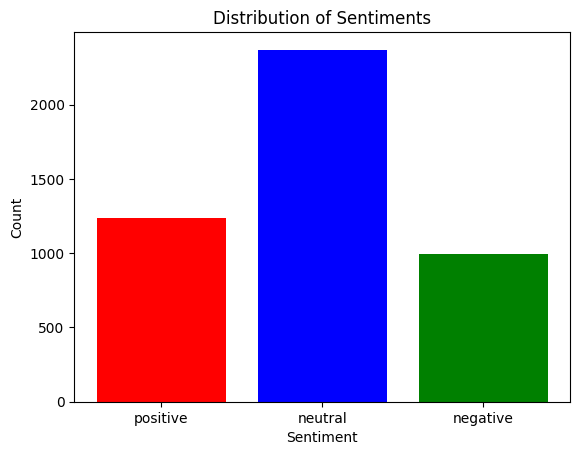

In [16]:
import matplotlib.pyplot as plt

counts = data["sentimen"].value_counts()  
desired_order = ['positive', 'neutral', 'negative']
ordered_counts = counts.reindex(desired_order, fill_value=0)
colors = ['red', 'blue', 'green'] 
plt.bar(ordered_counts.index, ordered_counts.values, color=colors)  

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiments")
plt.show()

In [17]:
data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join(x))


In [18]:
sentiment_mapping = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}
data['sentimen'] = data['sentimen'].map(sentiment_mapping)
data

,full_text,clean_text,score,sentimen
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling pas selesai ...,1,1
1,Syp utbk nya di gedung arsip unnes cung aku ga...,utbk gedung arsip cung teman,0,0
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cewek horor lihat temu,-3,-1
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat malam,0,0
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in one and only gaza,1,1
...,...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,bingung daftar dinas,-2,-1
4602,@unnesmenfess Belum buka nder,buka,0,0
4603,@unnesmenfess Qris bisa nder,qris,0,0
4604,https://t.co/05wpAe4Zpm,,0,0


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import random

# Assuming data is already loaded
X = data['clean_text']
y = data['sentimen']

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

,abad,abah,abal,abang,abaya,abdi,abiesst,abis,abisin,absen,...,yuuk,zaenuri,zaki,zaman,zhafira,zionis,zodiak,zona,zonk,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)


In [27]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definisikan nilai-nilai C yang akan diuji
C_values = [0.01, 0.1, 1, 10, 100]

# Iterasi untuk setiap kernel dan setiap nilai C
for kernel in ['linear', 'sigmoid', 'rbf', 'poly']:
    for C in C_values:
        # Tentukan model berdasarkan kernel yang digunakan
        if kernel == 'linear':
            model = SVC(kernel=kernel, C=C, random_state=random_seed)  # gamma tidak diperlukan
        elif kernel == 'poly':
            model = SVC(kernel=kernel, C=C, gamma=1, degree=3, random_state=random_seed)  # degree default adalah 3
        else:
            model = SVC(kernel=kernel, C=C, gamma=1, random_state=random_seed)
        
        # Latih model
        model.fit(X_train_smote, y_train_smote)
        
        # Prediksi dengan data uji
        y_pred = model.predict(X_test_tfidf)
        
        # Evaluasi performa model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy for SVM with {kernel} kernel and C={C}: {accuracy}")
        
        # Report klasifikasi dan confusion matrix
        print(f"Classification Report for {kernel} kernel with C={C}:\n", classification_report(y_test, y_pred))
        print(f"Confusion Matrix for {kernel} kernel with C={C}:\n", confusion_matrix(y_test, y_pred))
        print("\n" + "="*60 + "\n")


Accuracy for SVM with linear kernel and C=0.01: 0.6572668112798264
Classification Report for linear kernel with C=0.01:
               precision    recall  f1-score   support

          -1       0.71      0.17      0.27       200
           0       0.63      0.96      0.76       474
           1       0.75      0.47      0.58       248

    accuracy                           0.66       922
   macro avg       0.70      0.53      0.54       922
weighted avg       0.68      0.66      0.61       922

Confusion Matrix for linear kernel with C=0.01:
 [[ 34 143  23]
 [  3 456  15]
 [ 11 121 116]]


Accuracy for SVM with linear kernel and C=0.1: 0.7136659436008677
Classification Report for linear kernel with C=0.1:
               precision    recall  f1-score   support

          -1       0.76      0.40      0.52       200
           0       0.69      0.94      0.80       474
           1       0.78      0.54      0.64       248

    accuracy                           0.71       922
   macro a

In [29]:
# Fitness function
def fitness_function(params, X_train, y_train, X_test, y_test, kernel):
    C = params[0]
    
    # Adjust gamma and degree based on the kernel
    if kernel in ['rbf', 'sigmoid']:
        gamma = params[1]
    else:
        gamma = 'scale'  # Gamma not used for linear and poly
        
    if kernel == 'poly':
        degree = int(params[2])  # Ensure degree is an integer
        model = SVC(C=C, gamma=gamma, degree=degree, kernel=kernel, random_state=random_seed)
    else:
        model = SVC(C=C, gamma=gamma, kernel=kernel, random_state=random_seed)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Particle class for PSO
class Particle:
    def __init__(self, bounds):
        self.position = np.array([np.random.uniform(bound[0], bound[1]) for bound in bounds])
        self.velocity = np.random.uniform(-1, 1, len(bounds))
        self.best_position = self.position.copy()
        self.best_score = -1

# PSO optimization function
def pso_optimize(fitness_function, bounds, num_particles, max_iter, X_train, y_train, X_test, y_test, kernel):
    particles = [Particle(bounds) for _ in range(num_particles)]
    global_best_position = particles[0].position.copy()
    global_best_score = -1

    for _ in range(max_iter):
        for particle in particles:
            fitness = fitness_function(particle.position, X_train, y_train, X_test, y_test, kernel)
            if fitness > particle.best_score:
                particle.best_score = fitness
                particle.best_position = particle.position.copy()
            if fitness > global_best_score:
                global_best_score = fitness
                global_best_position = particle.position.copy()
        
        for particle in particles:
            inertia_weight = 0.5
            cognitive_weight = 2
            social_weight = 2

            inertia = inertia_weight * particle.velocity
            cognitive = cognitive_weight * np.random.rand() * (particle.best_position - particle.position)
            social = social_weight * np.random.rand() * (global_best_position - particle.position)
            
            particle.velocity = inertia + cognitive + social
            particle.position += particle.velocity

            # Ensure particles stay within bounds
            for i, bound in enumerate(bounds):
                if particle.position[i] < bound[0]:
                    particle.position[i] = bound[0]
                if particle.position[i] > bound[1]:
                    particle.position[i] = bound[1]
                    
    return global_best_position, global_best_score

# Kernels and parameter bounds
kernels = ['linear', 'sigmoid', 'rbf', 'poly']
bounds = {
    'linear': [(0.01, 100)],  # Only C
    'sigmoid': [(0.01, 100), (0.0001, 1)],  # C and gamma
    'rbf': [(0.01, 100), (0.0001, 1)],  # C and gamma
    'poly': [(0.01, 100), (0.0001, 1), (2, 5)]  # C, gamma, and degree
}

# SMOTE with random_state
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Iterate through each kernel
for kernel in kernels:
    bounds_for_kernel = bounds[kernel]

    # PSO optimization
    best_params, best_score = pso_optimize(fitness_function, bounds_for_kernel, num_particles=20, 
                                           max_iter=10, 
                                           X_train=X_train_smote, y_train=y_train_smote, 
                                           X_test=X_test_tfidf, y_test=y_test, 
                                           kernel=kernel)

    print(f"Optimal parameters for {kernel} kernel: {best_params}")

    # Train SVM with optimal parameters
    if kernel == 'poly':
        optimal_svm_clf = SVC(C=best_params[0], gamma=best_params[1], degree=int(best_params[2]), kernel=kernel, random_state=random_seed)
    else:
        optimal_svm_clf = SVC(C=best_params[0], gamma='scale' if kernel in ['linear'] else best_params[1], kernel=kernel, random_state=random_seed)

    optimal_svm_clf.fit(X_train_smote, y_train_smote)
    optimal_y_pred = optimal_svm_clf.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy_pso = accuracy_score(y_test, optimal_y_pred)
    print(f"SVM PSO Final Accuracy for {kernel} kernel: {accuracy_pso}")
    
    # Calculate and print confusion matrix
    cm = confusion_matrix(y_test, optimal_y_pred)
    print(f"Confusion Matrix for {kernel} kernel:\n{cm}")

    # Calculate and print classification report
    report = classification_report(y_test, optimal_y_pred)
    print(f"Classification Report for {kernel} kernel:\n{report}")
    
    print("\n" + "="*60 + "\n")


Optimal parameters for linear kernel: [3.3249632]
SVM PSO Final Accuracy for linear kernel: 0.8253796095444685
Confusion Matrix for linear kernel:
[[145  33  22]
 [ 16 429  29]
 [ 29  32 187]]
Classification Report for linear kernel:
              precision    recall  f1-score   support

          -1       0.76      0.72      0.74       200
           0       0.87      0.91      0.89       474
           1       0.79      0.75      0.77       248

    accuracy                           0.83       922
   macro avg       0.81      0.79      0.80       922
weighted avg       0.82      0.83      0.82       922

Optimal parameters for sigmoid kernel: [48.6104536   0.06512998]
SVM PSO Final Accuracy for sigmoid kernel: 0.8253796095444685
Confusion Matrix for sigmoid kernel:
[[145  33  22]
 [ 17 429  28]
 [ 29  32 187]]
Classification Report for sigmoid kernel:
              precision    recall  f1-score   support

          -1       0.76      0.72      0.74       200
           0       0.87 